In [2]:
### SKRIPT BY THOMAS BRIAN WINKLER
### PART OF THE ARTICLE "ENEGETICS AND DYNAMICS OF A STABLE BLOCH POINT" by Winkler et al. (2023)
from magnum import *
from math import *
import numpy as np
import random
import os.path
import os
import time
import sys
import re
import matplotlib.pyplot as plt
%matplotlib inline

[   INFO] - Imported FFTW wisdom from file
[   INFO] - ----------------------------------------------------------------------
[   INFO] - MicMag 2.0rc0
[   INFO] - Copyright (C) 2012 - 2023 by the MicroMagnum team and the MicMag2 contributors.
[   INFO] - This program comes with ABSOLUTELY NO WARRANTY.
[   INFO] - This is free software, and you are welcome to redistribute it under
[   INFO] - certain conditions; see the file COPYING in the distribution package.
[   INFO] - ----------------------------------------------------------------------
[   INFO] - Initializing CUDA
[   INFO] - cudaSucces0
[   INFO] - deviceCount0x7ffcc404db14
[   INFO] - There are 1 devices supporting CUDA
[   INFO] - Device 0 "NVIDIA GeForce RTX 2070 SUPER"
[   INFO] - Auto-selecting available GPU.
[   INFO] - FFTW using 1 threads from now on
[   INFO] - CUDA GPU support: yes


In [3]:
def calc(nt, system, sample):
    nar = 100        # radius in units of FeGe lattice constant
    naz1 = 30        # bottom layer thickness in units of FeGe lattice constants
    naz2  = 20       # top layer thickness in units of FeGe lattice constants
    
    a=0.4679*1e-09   # lattice constant of FeGe in m
    random.seed(0)
    t=(naz1+naz2)*a  #total thickness in [m]
    r=nar*a          #radius in [m]
    dia=2*r          #diameter in [m]  
    d = a*(naz1+naz2)/nt   #MM mesh size in [m] 
    nmmz = nt              # number of MM cells in z-direction
    nmm =int(round(dia/d)) # number of MM cells in x- and y-direction
    
    mu0 = 4*np.pi*1e-7   #mu0
    alpha = 0.28         #damping constant
    D  = 1.58*1e-3          #DMI [J/m**2]
    A  = 8.78*1e-12         #Exchange constant in [J/m]
    Ms = 0.384*1e6
    mu = Ms*a**3            #magnetic moment (for HB)
    J  = 2*A*a
    DISK = Material({
    'id': 'DISK',
    'Ms': Ms,
    'alpha': alpha,
    'A': A,
    'axis1': (0,0,1),
    'axis2': (0,1,0),
    'k_uniaxial': 0.0,
    'k_cubic': 0.0,
    'l':a,
    'mu':mu,
    'J':J})
    
    relax = 0.5 # degree per nanosecond relax condition

    mesh = RectangularMesh((nmm, nmm, nmmz), (d, d, d))
    if sample == "rectangular":
        disk = Cuboid((0,0,0), (nmm*d,nmm*d,nmmz*d))
    if sample == "cylindrical":
        disk = Cylinder((nmm*d/2, nmm*d/2,0.0),(nmm*d/2, nmm*d/2,nmmz*d), nmm*d/2)
    world = World(mesh, Body("disk", DISK, disk))
    
    solver = create_solver(world, module_list =[FSStrayField, FSExchangeField,  FSDMIField],
                           finescale = True,  log=False, do_precess = True) # finescale sets either MM (False) or HB mode (True).
   
    folder = system+"/HB_"+sample+"/"
    folderwrite = system+"/HB_"+sample+"/nucleation_"+str(nt)+"/"

    if not os.path.isdir(folder): os.mkdir(folder)
    if not os.path.isdir(folderwrite): os.mkdir(folderwrite)

    solver.state.M= (0,0,mu)
    
    def fillDMIx(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (-D, 0, 0)
        else:
            return (D, 0, 0)

    def fillDMIy(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0, -D, 0)
        else:
            return (0, D, 0)

    def fillDMIz(field, pos):
        x,y,z = pos
        if z<(naz1*a):
            return (0,0, 0)
        else:
            return (0, 0, 0)

    solver.state.Dx = fillDMIx  #fill DMI tensor 
    solver.state.Dy = fillDMIy  #fill DMI tensor
    solver.state.Dz = fillDMIz  #fill DMI tensor
    solver.state.M.normalize(1) # normalize spins to 1 for writing
    filenameinit = system+"_FMinit_nt_"+str(nt)+".omf"
    
    writeOMF(folder+filenameinit, solver.state.M)
    numpymag = solver.state.M.to_numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization bottom")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,0], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("x-magnetization bottom")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,-1,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization top")
    plt.show()
     
    solver.state.M.normalize(mu)
    solver.addStepHandler(OOMMFStorage(folderwrite, "M"), condition.EveryNthSecond(2e-11))
    solver.relax(relax)
    
    solver.state.M.normalize(1) # normalize spins to 1 for writing
    filename_relaxed = system+"_relaxed_nt_"+str(nt)+".omf"
    writeOMF(folder+filename_relaxed, solver.state.M)    
    
    numpymag = solver.state.M.to_numpy()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization bottom")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,0,0], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("x-magnetization bottom")
    plt.show()
    plt.figure(figsize=(3,3))
    plt.imshow(numpymag[:,:,-1,2], vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("z-magnetization top")
    plt.show()


[   INFO] - LandauLifshitzGilbert module configuration:
[   INFO] -  - H_tot = H_stray + H_exch + H_dmi
[   INFO] -  - E_tot = E_stray + E_exch + E_dmi
[   INFO] -  - dM/dt = LLGE(M, H_tot)
[   INFO] - Performance hint: The number of cells nx, ny, nz in each direction should satisfy nx >= ny >= nz.
[   INFO] - Setting up demagnetization tensor field
[   INFO] -   Magn. size      : 200x200x50 cells
[   INFO] -   FFT size        : 400x400x100
[   INFO] -   PBC dimensions  : none  (1 repetitions)
[   INFO] -   Cache file      : /uni-mainz.de/homes/twinkler/.cache/magnum/Demag--200-200-50--400-400-100--467-467-467.dat
[   INFO] -   0%
[   INFO] -   50%
[   INFO] -   100%
[   INFO] - Initialized modules: LandauLifshitzGilbert, FSStrayField, FSExchangeField, FSDMIField
[   INFO] - Initializing material parameters
[   INFO] -   body id='disk', volume=100.0%, params: 'mu=3.9336e-23', 'alpha=0.28', 'J=8.21632e-21'
[   INFO] - Runge Kutta evolver: method is rkf45, step size controller is MMM(eps

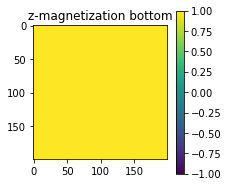

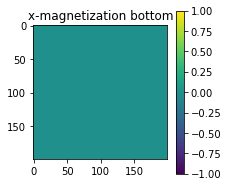

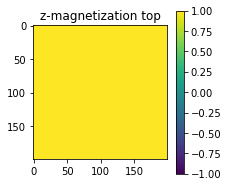


==============[Solver interrupted by signal SIGINT (ctrl-c)]==============
State:
       step = 226010
          t = 1.3957187354846663e-09
     avg(M) = (5.138686419410361e-31, -1.1661006561667466e-31, -6.500526460982569e-25)
 deg_per_ns = 0.671437559746371

Mesh: RectangularMesh((200, 200, 50), (4.679e-10, 4.679e-10, 4.679e-10), periodic_bc='', periodic_repeat=1)

Options:
  1. Continue
  2. Stop solver and return the current state as the result
  3. Save current magnetization to .omf file, then continue
  4. Raise KeyboardInterrupt
  5. Kill program
  6. Start debugger
  7. Toggle console log (now:disabled)
Choice: 1


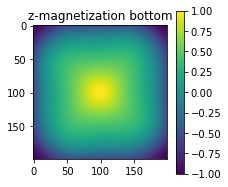

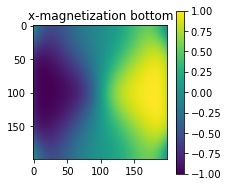

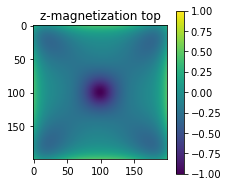

In [4]:
system= "BP" #chossing configurations Bloch point (BP)

if os.path.isfile(system):
    os.mkdir(system)

for nt in[ 50]: # thickness in units of FeGe lattice constant, in study [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90]. 50 equals the atomistic lattice constant.
    for sample in ["rectangular"]:
        calc(nt, system, sample)
